In [1]:
%%capture nop
import os 
IS_KAGGLE = not not os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if IS_KAGGLE:
    !git clone https://github.com/Janluke0/PoS-Tagging/
    os.chdir('PoS-Tagging')
    !pip install positional-encodings bpemb
else:
    os.chdir('..')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
GPU = 1 if torch.cuda.is_available() else 0

In [3]:
from dataset.tokenizer import get_tokenizer
from dataset.twtita import mk_dataloaders, TWITADS

import model.recurrent.gru as gru
from model import TokenOfSeqClassifier

TAGS = TWITADS._TAGS

In [4]:
available = ["BPE", "WordPiece","BERT_pretrained", "ELECTRA_pretrained", "ROBERTA_pretrained", "DBERT_pretrained"]

In [5]:
def mk4tknzr(name):
    tknzr = get_tokenizer('resampled_train',name)
    ntags, dl_train = mk_dataloaders(tknzr,['resampled_train'],batch_size=256)
    vocab = tknzr.vocab_size if hasattr(tknzr,'vocab_size')  else tknzr.get_vocab_size()
    _, dl_val, dl_test = mk_dataloaders(tknzr,['resampled_validation','test'], shuffle=False,batch_size=256)
    model =  gru.TokenOfSeqClassifier(d_input=vocab, d_model=128, d_output=ntags, dropout=0.1,add_embedding_projection=True)
    pl_model = TokenOfSeqClassifier(model, 
                                    nclass=len(TAGS),
                                    label_idx_to_ignore=[ TAGS['[EPAD]'],TAGS['[BOS]'], TAGS['[EOS]'], TAGS['[PAD]']])
    return pl_model, (dl_train,dl_val, dl_test)

def plot_curves(model):
    acc, loss = model.val_metrics['accuracy'],model.val_metrics['loss']
    print(acc[-1],max(acc))
    print(loss[-1],min(loss))
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.plot(acc)
    plt.subplot(122)
    plt.plot(loss)
    
early_stopping = lambda: pl.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-6,mode='max',patience=400)
checkpoints = lambda: pl.callbacks.ModelCheckpoint(monitor='val_acc',mode='max')

In [6]:
#%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('BPE')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
#trainer.fit(model, dl_train, dl_val)
ckpt = '/kaggle/input/gru-tknzr-comparison/PoS-Tagging/lightning_logs/version_0/checkpoints/epoch=1337-step=30773.ckpt'
model.eval()
with torch.no_grad():
    print('test')
    trainer.validate(model,dl_test,ckpt_path=ckpt)
    print('validation')
    trainer.validate(model,dl_val,ckpt_path=ckpt)
    print('train')
    trainer.validate(model,dl_train,ckpt_path=ckpt)




test


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8795965313911438,
 'val_loss': 0.47503119707107544,
 'val_raw_acc': 0.9525017738342285}
--------------------------------------------------------------------------------
validation


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9296312928199768,
 'val_loss': 0.26907551288604736,
 'val_raw_acc': 0.9677681922912598}
--------------------------------------------------------------------------------
train


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9998937249183655,
 'val_loss': 8.122820145217702e-05,
 'val_raw_acc': 0.9999508857727051}
--------------------------------------------------------------------------------


In [7]:
#%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('WordPiece')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
#trainer.fit(model, dl_train, dl_val)
ckpt = '/kaggle/input/gru-tknzr-comparison/PoS-Tagging/lightning_logs/version_1/checkpoints/epoch=1579-step=36339.ckpt'
model.eval()
with torch.no_grad():
    print('test')
    trainer.validate(model,dl_test,ckpt_path=ckpt)
    print('validation')
    trainer.validate(model,dl_val,ckpt_path=ckpt)
    print('train')
    trainer.validate(model,dl_train,ckpt_path=ckpt)




test


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8490962386131287,
 'val_loss': 0.6783570051193237,
 'val_raw_acc': 0.933262825012207}
--------------------------------------------------------------------------------
validation


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9013508558273315,
 'val_loss': 0.45465463399887085,
 'val_raw_acc': 0.9499934911727905}
--------------------------------------------------------------------------------
train


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.978682279586792,
 'val_loss': 0.07192661613225937,
 'val_raw_acc': 0.9889272451400757}
--------------------------------------------------------------------------------


In [8]:
#%%capture nop
model, (dl_train,dl_val, dl_test) = mk4tknzr('BERT_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
#trainer.fit(model, dl_train, dl_val)
ckpt = '/kaggle/input/gru-tknzr-comparison/PoS-Tagging/lightning_logs/version_2/checkpoints/epoch=1494-step=34384.ckpt'
model.eval()
with torch.no_grad():
    print('test')
    trainer.validate(model,dl_test,ckpt_path=ckpt)
    print('validation')
    trainer.validate(model,dl_val,ckpt_path=ckpt)
    print('train')
    trainer.validate(model,dl_train,ckpt_path=ckpt)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/237k [00:00<?, ?B/s]

test


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8484657406806946,
 'val_loss': 1.0207617282867432,
 'val_raw_acc': 0.9011620879173279}
--------------------------------------------------------------------------------
validation


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9042837023735046,
 'val_loss': 0.6684111952781677,
 'val_raw_acc': 0.9321320056915283}
--------------------------------------------------------------------------------
train


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9998937249183655,
 'val_loss': 0.00011637011630227789,
 'val_raw_acc': 0.9999266862869263}
--------------------------------------------------------------------------------


In [9]:
#%%capture nop
model, (dl_train,dl_val, dl_test) = mk4tknzr('DBERT_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
#trainer.fit(model, dl_train, dl_val)
ckpt = '/kaggle/input/gru-tknzr-comparison/PoS-Tagging/lightning_logs/version_3/checkpoints/epoch=1870-step=43032.ckpt'
model.eval()
with torch.no_grad():
    print('test')
    trainer.validate(model,dl_test,ckpt_path=ckpt)
    print('validation')
    trainer.validate(model,dl_val,ckpt_path=ckpt)
    print('train')
    trainer.validate(model,dl_train,ckpt_path=ckpt)

Downloading:   0%|          | 0.00/270 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/876 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

test


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8434215784072876,
 'val_loss': 0.9177127480506897,
 'val_raw_acc': 0.9148892164230347}
--------------------------------------------------------------------------------
validation


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9104397892951965,
 'val_loss': 0.5282232165336609,
 'val_raw_acc': 0.946739673614502}
--------------------------------------------------------------------------------
train


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9999420046806335,
 'val_loss': 5.373969906941056e-05,
 'val_raw_acc': 0.9999635815620422}
--------------------------------------------------------------------------------


In [10]:
#%%capture nop
model, (dl_train,dl_val,dl_train) = mk4tknzr('ELECTRA_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
#trainer.fit(model, dl_train, dl_val)
ckpt = '/kaggle/input/gru-tknzr-comparison/PoS-Tagging/lightning_logs/version_4/checkpoints/epoch=352-step=8118.ckpt'
model.eval()
with torch.no_grad():
    print('test')
    #trainer.validate(model,dl_test,ckpt_path=ckpt)
    print('validation')
    trainer.validate(model,dl_val,ckpt_path=ckpt)
    print('train')
    trainer.validate(model,dl_train,ckpt_path=ckpt)

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

test
validation


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8961350321769714,
 'val_loss': 0.5948903560638428,
 'val_raw_acc': 0.9309455156326294}
--------------------------------------------------------------------------------
train


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8255569338798523,
 'val_loss': 0.9308404922485352,
 'val_raw_acc': 0.8939377069473267}
--------------------------------------------------------------------------------


In [11]:
#%%capture nop
model, (dl_train,dl_val, dl_train) = mk4tknzr('ROBERTA_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
#trainer.fit(model, dl_train, dl_val)
ckpt = '/kaggle/input/gru-tknzr-comparison/PoS-Tagging/lightning_logs/version_5/checkpoints/epoch=1640-step=37742.ckpt'
model.eval()
with torch.no_grad():
    print('test')
    trainer.validate(model,dl_test,ckpt_path=ckpt)
    print('validation')
    trainer.validate(model,dl_val,ckpt_path=ckpt)
    print('train')
    trainer.validate(model,dl_train,ckpt_path=ckpt)

Downloading:   0%|          | 0.00/212 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/982 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

test


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.045187052339315414,
 'val_loss': 14.954180717468262,
 'val_raw_acc': 0.26635754108428955}
--------------------------------------------------------------------------------
validation


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9171923398971558,
 'val_loss': 0.5416010618209839,
 'val_raw_acc': 0.9486397504806519}
--------------------------------------------------------------------------------
train


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.8497583270072937,
 'val_loss': 1.0464365482330322,
 'val_raw_acc': 0.9100334048271179}
--------------------------------------------------------------------------------


0.8497583270072937 0.9171923398971558
1.037693738937378 0.5320355296134949


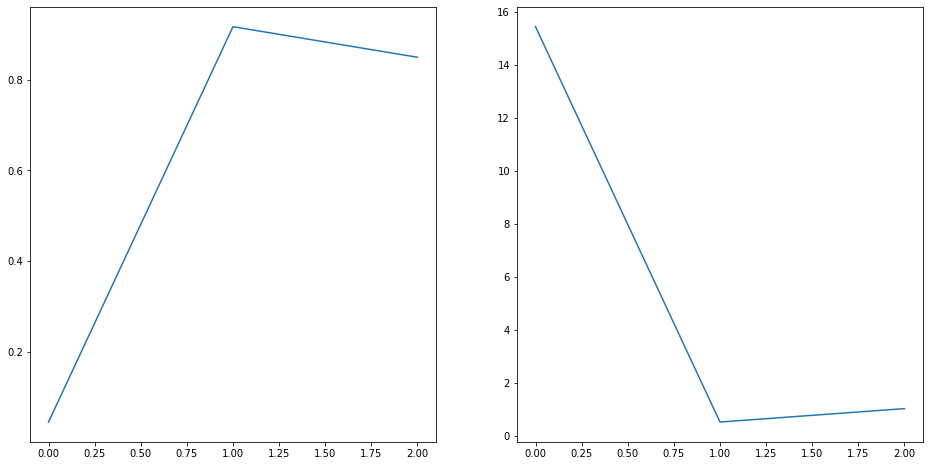

In [12]:
plot_curves(model)
del model,dl_train,dl_val